In [1]:
import numpy as np


Device: cuda

 Stage 1: Adam Training
Epoch     0/2001 | loss=1.421846e+02 | Eint=1.4176e+02 | Eext=-2.4124e-01 | R_eq=1.8793e-01
Epoch   200/2001 | loss=-4.546921e-01 | Eint=4.5427e-01 | Eext=9.0950e-01 | R_eq=5.3274e-04
Epoch   400/2001 | loss=-4.548467e-01 | Eint=4.5438e-01 | Eext=9.0962e-01 | R_eq=3.9210e-04
Epoch   600/2001 | loss=-4.549065e-01 | Eint=4.5443e-01 | Eext=9.0968e-01 | R_eq=3.3801e-04
Epoch   800/2001 | loss=-4.549637e-01 | Eint=4.5448e-01 | Eext=9.0973e-01 | R_eq=2.8524e-04
Epoch  1000/2001 | loss=-4.550193e-01 | Eint=4.5453e-01 | Eext=9.0979e-01 | R_eq=2.3474e-04
Epoch  1200/2001 | loss=-4.550710e-01 | Eint=4.5459e-01 | Eext=9.0985e-01 | R_eq=1.8915e-04
Epoch  1400/2001 | loss=-4.551174e-01 | Eint=4.5465e-01 | Eext=9.0992e-01 | R_eq=1.5018e-04
Epoch  1600/2001 | loss=-4.551581e-01 | Eint=4.5470e-01 | Eext=9.0998e-01 | R_eq=1.1858e-04
Epoch  1800/2001 | loss=-4.551934e-01 | Eint=4.5475e-01 | Eext=9.1004e-01 | R_eq=9.4210e-05
Epoch  2000/2001 | loss=-4.552242e-01 | Ei

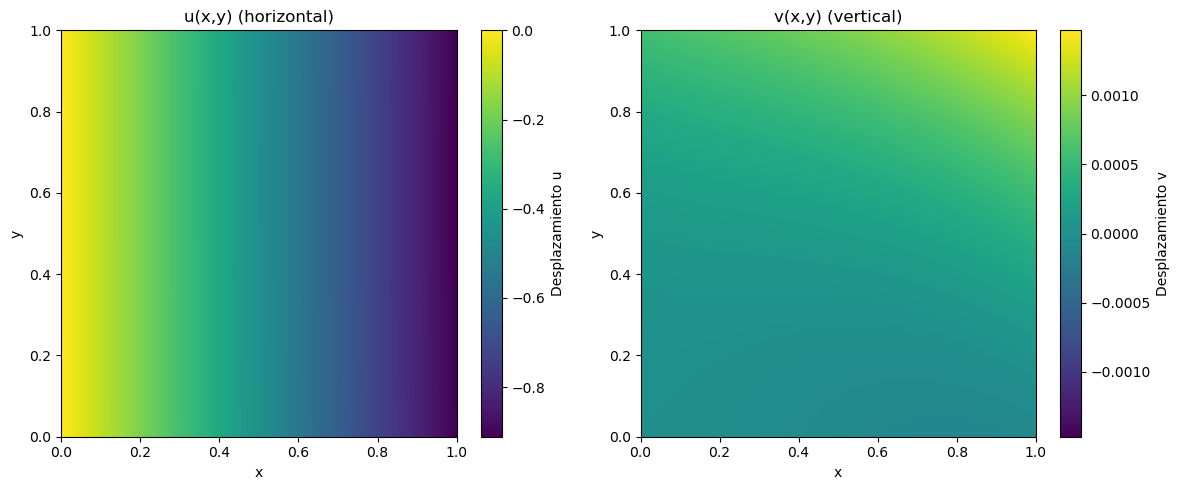

In [2]:
# ============================================================
# Código completo corregido listo para ejecutar
# ============================================================

# (Asumo que ya tienes importadas las librerías: numpy, torch, nn, time, matplotlib, random)
import numpy as np
import torch
import torch.nn as nn
import time
import random
import matplotlib.pyplot as plt

# ============================================================
# 1. Device setup and reproducibility
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

manualSeed = 1234
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# ============================================================
# 2. Neural network definition
# ============================================================
class Net2D(nn.Module):
    def __init__(self, n_input=2, n_output=2, n_layer=8, n_nodes=80):
        super().__init__()
        self.input = nn.Linear(n_input, n_nodes)
        self.hidden = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for _ in range(n_layer)])
        self.output = nn.Linear(n_nodes, n_output)
        
        # Xavier initialization
        for L in [self.input, self.output] + list(self.hidden):
            nn.init.xavier_uniform_(L.weight)
            nn.init.normal_(L.bias, std=1e-3)

        # Sine activation (para campos suaves/oscillatorios)
        self.act = torch.sin

    def forward(self, x):
        y = self.act(self.input(x))
        for L in self.hidden:
            y = self.act(L(y))
        return self.output(y)  # -> [u, v]

# ============================================================
# 3. Domain definition and collocation points
# ============================================================
nelx, nely = 150, 150
xs = np.linspace(0.0, 1.0, nelx + 1)
ys = np.linspace(0.0, 1.0, nely + 1)
X, Y = np.meshgrid(xs, ys)
pts = np.hstack([X.reshape(-1, 1, order='F'), Y.reshape(-1, 1, order='F')])
N_total = pts.shape[0]

# Convert to torch tensor
data = torch.tensor(pts, dtype=torch.float32, device=device, requires_grad=True)

# Boundary indices (right edge x = 1.0)
tol = 1e-6
right_idx = np.where(np.abs(pts[:, 0] - 1.0) < tol)[0]
right_idx_t = torch.tensor(right_idx, dtype=torch.long, device=device)

# Boundary indices (left edge x = 0.0)
left_idx = np.where(np.abs(pts[:, 0] - 0.0) < tol)[0]
left_idx_t = torch.tensor(left_idx, dtype=torch.long, device=device)

# Reference index for fixing v (single point, e.g. bottom-left (0,0))
ref_idx_arr = np.where((np.abs(pts[:,0] - 0.0) < tol) & (np.abs(pts[:,1] - 0.0) < tol))[0]
if len(ref_idx_arr) == 0:
    # fallback: take the first left index
    ref_idx = left_idx[0]
else:
    ref_idx = ref_idx_arr[0]
ref_idx_t = torch.tensor(ref_idx, dtype=torch.long, device=device)

# ============================================================
# 4. Material and loading definition
# ============================================================
nu = 0.3               # Poisson's ratio
T = 1.0                # Traction on right edge
# Use scalar Young's modulus to simplify broadcasting and debugging
E_node = torch.tensor(1.0, device=device)  # escalar homogéneo

# ============================================================
# 5. Build the neural network
# ============================================================
net_uv = Net2D(n_input=2, n_output=2, n_layer=8, n_nodes=80).to(device)

# Boundary injection: u=0 on x=0 (via multiplicación por x), v libre excepto en un punto de referencia
def uv_tilde(pt):
    xcoord = pt[:, 0:1]            # shape [N,1]
    out = net_uv(pt)               # shape [N,2]
    u_net = out[:, 0:1]
    v_net = out[:, 1:2]

    # Imponer u = 0 en x = 0
    u = xcoord * u_net

    # Para v: permitir variación libre; eliminar traslación rígida vertical fijando un punto
    v = v_net
    v_ref = v[ref_idx_t]           # valor en el punto de referencia
    v = v - v_ref                  # ahora v[ref_idx] == 0

    return torch.cat([u, v], dim=1)

# ============================================================
# 6. Energy functional (loss) corregida
# ============================================================
def energy_loss_barrier(alpha=1e-2, beta=1e-2, eps=1e-8, w_eq=1.0):
    """Compute total energy + equilibrium residual (con signos y BC corregidos)."""
    uv = uv_tilde(data)
    u, v = uv[:, 0:1], uv[:, 1:2]

    # Derivatives
    du = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dv = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)[0]

    du_x, du_y = du[:, 0:1], du[:, 1:2]
    dv_x, dv_y = dv[:, 0:1], dv[:, 1:2]

    # Strains (small strain theory)
    ex = du_x
    ey = dv_y
    gamma_xy = du_y + dv_x

    # Constitutive law (plane stress)
    G = E_node / (2.0 * (1.0 + nu))
    lam = E_node * nu / (1.0 - nu**2)

    sx = 2.0 * G * ex + lam * (ex + ey)
    sy = 2.0 * G * ey + lam * (ex + ey)
    txy = G * gamma_xy

    # Internal energy density and average (approx integral por promedio)
    # Nota: gamma_xy aquí está definida como du_y + dv_x (no 2*eps_xy)
    w_density = 0.5 * (sx * ex + sy * ey + txy * gamma_xy)
    Eint = torch.mean(w_density)

    # External energy (trabajo de la tracción en la frontera derecha)
    u_boundary = u[right_idx_t]
    # Usamos la convención Eext = - ∫ T u dΓ -> en promedio: - T*mean(u_boundary)
    Eext = - T * torch.mean(u_boundary)

    # ---------- Equilibrium residual (∇·σ) ----------
    dsx_dx = torch.autograd.grad(sx, data, torch.ones_like(sx), retain_graph=True, create_graph=True)[0][:, 0:1]
    dsy_dy = torch.autograd.grad(sy, data, torch.ones_like(sy), retain_graph=True, create_graph=True)[0][:, 1:1+1]
    dtxy_dx = torch.autograd.grad(txy, data, torch.ones_like(txy), retain_graph=True, create_graph=True)[0][:, 0:1]
    dtxy_dy = torch.autograd.grad(txy, data, torch.ones_like(txy), retain_graph=True, create_graph=True)[0][:, 1:1+1]

    rx = dsx_dx + dtxy_dy
    ry = dtxy_dx + dsy_dy
    equilibrium_residual = torch.mean(rx**2 + ry**2)

    # ---------- Total loss ----------
    loss = (Eint - Eext) + w_eq * equilibrium_residual

    return loss, Eint, Eext, equilibrium_residual

# ============================================================
# 7. Stage 1: Pretraining with Adam
# ============================================================
epochs = 2001
lr = 1e-3
optimizer = torch.optim.Adam(net_uv.parameters(), lr=lr)
loss_history = []

print("\n=====================")
print(" Stage 1: Adam Training")
print("=====================")
start = time.time()

for ep in range(epochs):
    optimizer.zero_grad()
    loss, Eint, Eext, R_eq = energy_loss_barrier(w_eq=1.0)

    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    loss_history.append(loss_val)
    if ep % 200 == 0 or ep == epochs - 1:
        print(f"Epoch {ep:5d}/{epochs} | loss={loss_val:.6e} | Eint={Eint.item():.4e} | Eext={Eext.item():.4e} | R_eq={R_eq.item():.4e}")

print(f"Adam training completed in {(time.time()-start):.2f} s")

# ============================================================
# 8. Visualización de resultados (u, v)
# ============================================================
# Evaluar la red en todo el dominio (ya está en `data`)
uv_final = uv_tilde(data).detach().cpu().numpy()  # shape [N,2]
u = uv_final[:, 0]
v = uv_final[:, 1]

# Reshape usando order='F' para coincidir con la construcción inicial de pts
U = u.reshape((nely+1, nelx+1), order='F')
V = v.reshape((nely+1, nelx+1), order='F')

# Determinar escalas para visualizar coherentemente
u_absmax = np.max(np.abs(U))
v_absmax = np.max(np.abs(V))
v_sym = max(v_absmax, 1e-8)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im0 = axs[0].imshow(U, extent=[0,1,0,1], origin='lower', aspect='auto')
axs[0].set_title("u(x,y) (horizontal)")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0], label="Desplazamiento u")

im1 = axs[1].imshow(V, extent=[0,1,0,1], origin='lower', aspect='auto', vmin=-v_sym, vmax=v_sym)
axs[1].set_title("v(x,y) (vertical)")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(im1, ax=axs[1], label="Desplazamiento v")

plt.tight_layout()
plt.show()
